In [1]:
import numpy as np
import seaborn as sns
import math

In [2]:
WIDTH = 1000
HEIGHT = 800
AIRCRAFT_SIZE = 24
COLLISION_RADIUS = 2 * AIRCRAFT_SIZE
GOAL_RADIUS = 2 * COLLISION_RADIUS
SAFE_DISTANCE = 4 * COLLISION_RADIUS

FPS = 100
AIRSPEED = 120
MAX_STEPS = 1200

REWARD_GOAL = 1000
REWARD_COLLISION = -1000

In [3]:
goal_x = WIDTH - GOAL_RADIUS
goal_y = HEIGHT / 2

d_separation_max = round(np.sqrt(WIDTH**2 + HEIGHT**2)) + (2 * (AIRSPEED / FPS) * MAX_STEPS)
d_goal_init = (WIDTH - GOAL_RADIUS) - (2 * AIRCRAFT_SIZE)
d_goal_max = d_goal_init + (AIRSPEED / FPS) * MAX_STEPS
d_path_max = 2 * (d_goal_init)

In [4]:
print(d_separation_max)

4161.0


In [5]:
print(d_goal_init)

856


In [6]:
print(d_goal_max)

2296.0


In [7]:
print(d_path_max)

1712


In [8]:
# Path length reward

In [9]:
def path_length_reward(d_path, exp=2):
    if d_path >= 0:
        d_path_max = 2 * (WIDTH + HEIGHT)
        return max(0, (1 - d_path / d_path_max) ** exp)
    else:
        raise ValueError("Distance covered cannot be negative.")

In [10]:
dp_values = np.linspace(0, 3 * d_goal_init, 100)
rdp_values = np.array([path_length_reward(x) for x in dp_values])

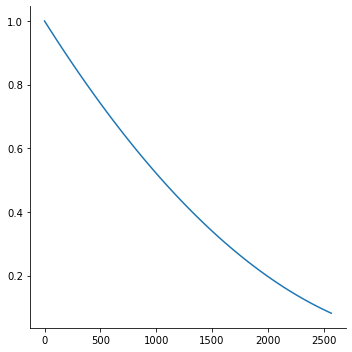

In [11]:
sns.relplot(x = dp_values, y=rdp_values, kind='line')

In [12]:
path_length_reward(d_goal_init)

0.5809827160493828

In [13]:
path_length_reward(WIDTH+HEIGHT)

0.25

In [14]:
path_length_reward(2*(WIDTH+HEIGHT))

0

In [15]:
# Distance reward

In [16]:
def distance_reward(d_goal, exp=4):
    if d_goal >= 0:
        d_goal_init = (WIDTH - GOAL_RADIUS) - (2 * AIRCRAFT_SIZE)
        d_goal_max = d_goal_init + (AIRSPEED / FPS) * MAX_STEPS
        return min(1, (1 - d_goal / d_goal_max) ** exp)
    else:
        raise ValueError("Distance to goal cannot be negative.")

In [17]:
d_values = np.linspace(0, d_goal_max, 300)
rd_values = np.array([distance_reward(x) for x in d_values])

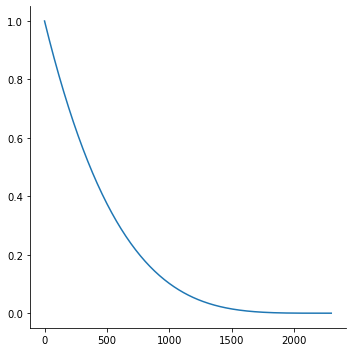

In [18]:
sns.relplot(x = d_values, y=rd_values, kind='line')

In [19]:
print(distance_reward(0))
print(distance_reward(COLLISION_RADIUS))
print(distance_reward(GOAL_RADIUS))
print(distance_reward(SAFE_DISTANCE))
print(distance_reward(d_goal_max))

1
0.9189622950516945
0.8429526657055691
0.7051725641148902
0.0


In [20]:
# Heading reward

In [21]:
def delta_heading(psi, phi):
    return min(abs(psi-phi), abs(psi-phi-360))

In [22]:
def heading_reward(psi, phi, exp=4):
    if (0 <= psi <= 360) and (0 <= phi <= 360):
        return (1 - delta_heading(psi, phi) / 180) ** exp
    else:
        raise ValueError("Heading and relative angle must be in [0, 360].")

In [23]:
psi_space = np.linspace(0, 360, 361)
dh_space = np.array([delta_heading(psi, 0) for psi in psi_space])
hr_space = np.array([heading_reward(psi, 0) for psi in psi_space])

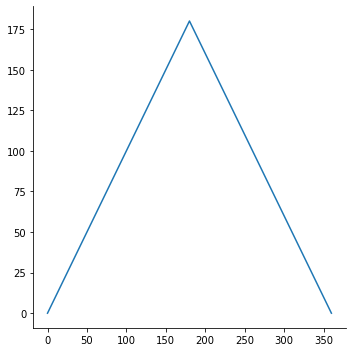

In [24]:
sns.relplot(x = psi_space, 
            y = dh_space,  
            kind='line')

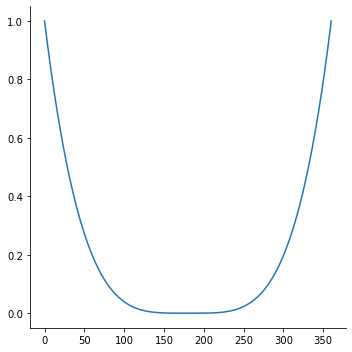

In [25]:
sns.relplot(x = psi_space, 
            y = hr_space,  
            kind='line')

In [26]:
phi = 0
print(heading_reward(0, phi))
print(heading_reward(10, phi))
print(heading_reward(350, phi))
print(heading_reward(20, phi))
print(heading_reward(340, phi))
print(heading_reward(30, phi))
print(heading_reward(330, phi))
print(heading_reward(40, phi))
print(heading_reward(320, phi))

1.0
0.7956199512269471
0.7956199512269471
0.624295076969974
0.624295076969974
0.4822530864197532
0.4822530864197532
0.3659503124523701
0.3659503124523701


In [27]:
# Closest point of approach distance reward

In [28]:
def closest_approach_reward(v_closing, d_cpa, exp=4):
    if v_closing > 0:
        return 1
    else:
        return min(1, (d_cpa / SAFE_DISTANCE) ** exp)

In [29]:
v_closing = -1
d_values = np.linspace(-1.5 * SAFE_DISTANCE, 1.5 * SAFE_DISTANCE, 300)
rc_values = np.array([closest_approach_reward(v_closing, d) for d in d_values])

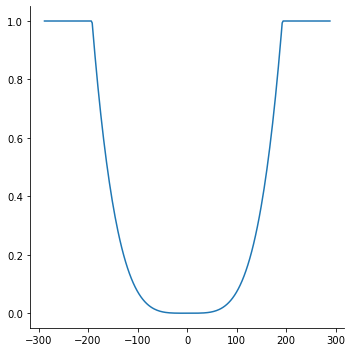

In [30]:
sns.relplot(x = d_values, y=rc_values, kind='line')

In [31]:
print(closest_approach_reward(-1, 0))
print(closest_approach_reward(-1, SAFE_DISTANCE/4))
print(closest_approach_reward(-1, -SAFE_DISTANCE/4))
print(closest_approach_reward(-1, SAFE_DISTANCE/2))
print(closest_approach_reward(-1, -SAFE_DISTANCE/2))
print(closest_approach_reward(-1, 3*SAFE_DISTANCE/4))
print(closest_approach_reward(-1, -3*SAFE_DISTANCE/4))
print(closest_approach_reward(-1, SAFE_DISTANCE))
print(closest_approach_reward(-1, -SAFE_DISTANCE))

0.0
0.00390625
0.00390625
0.0625
0.0625
0.31640625
0.31640625
1
1


In [32]:
# Plan deviation reward

In [33]:
def plan_deviation_reward(d_dev, exp=0.5):
    # d_dev can be positive or negative, depending on the side of the deviation (up or down)
    d_dev = abs(d_dev)
    d_goal_init = (WIDTH - GOAL_RADIUS) - (2 * AIRCRAFT_SIZE)
    d_dev_max = d_goal_init / 2
    if d_dev > d_dev_max:
        return 0
    else:
        return (1 - d_dev / d_dev_max) ** exp

In [34]:
d_values = np.linspace(-3*d_goal_init/4, 3*d_goal_init/4, 300)
rd_values = np.array([plan_deviation_reward(x) for x in d_values])

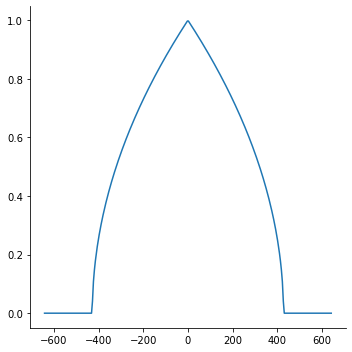

In [35]:
sns.relplot(x = d_values, y=rd_values, kind='line')

In [36]:
print(plan_deviation_reward(0))
print(plan_deviation_reward(COLLISION_RADIUS))
print(plan_deviation_reward(-COLLISION_RADIUS))
print(plan_deviation_reward(GOAL_RADIUS))
print(plan_deviation_reward(-GOAL_RADIUS))
print(plan_deviation_reward(SAFE_DISTANCE))
print(plan_deviation_reward(-SAFE_DISTANCE))
print(plan_deviation_reward(d_goal_init/4))
print(plan_deviation_reward(-d_goal_init/4))
print(plan_deviation_reward(d_goal_init/3))
print(plan_deviation_reward(-d_goal_init/3))
print(plan_deviation_reward(d_goal_init/2))
print(plan_deviation_reward(-d_goal_init/2))

1.0
0.9422581744350746
0.9422581744350746
0.8807388571985678
0.8807388571985678
0.7425643872142526
0.7425643872142526
0.7071067811865476
0.7071067811865476
0.5773502691896258
0.5773502691896258
0.0
0.0
